In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stat
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#import keras 
#from keras.models import Sequential
#from keras.layers import Dense
import warnings

In [2]:
#load data
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/house_model_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())
display(house_df.describe())

(9974, 20)

,is_incumbent,party,percent,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,fundraising,district,president_party,last_house_majority,name,state
0,0.0,D,42.1,4281,1,1824,1824.0,0,5.790196,0.0,1.0,0.43832,200.179856,182.503597,567730.665279,District 1,0,D,Ratliff Boon,Indiana
1,1.0,D,42.8,5202,1,1826,1824.0,1,5.790196,0.0,1.0,0.43832,200.179856,182.503597,567730.665279,District 1,0,D,Ratliff Boon,Indiana
2,1.0,D,52.2,7272,1,1828,1824.0,2,5.790196,0.0,1.0,0.43832,200.179856,182.503597,567730.665279,District 1,0,D,Ratliff Boon,Indiana
3,0.0,D,49.1,10868,0,1830,1860.0,0,5.790196,0.0,1.0,0.43832,200.179856,182.503597,567730.665279,District 1,0,D,John Law,Indiana
4,1.0,D,50.9,11280,1,1830,1824.0,3,5.790196,0.0,1.0,0.43832,200.179856,182.503597,567730.665279,District 1,0,D,Ratliff Boon,Indiana


,is_incumbent,percent,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,fundraising
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9.974000e+03
mean,0.444456,50.968786,101123.196310,0.528474,1991.993884,1102.728093,0.963305,6.176784,0.481251,0.604071,0.484303,219.603971,210.664830,6.981911e+05
std,0.496930,19.917918,55100.387492,0.499214,31.278231,987.884433,1.826929,2.060743,0.499673,0.489074,0.063275,36.152015,34.645436,7.986861e+05
min,0.000000,0.000000,0.000000,0.000000,1824.000000,0.000000,0.000000,2.700000,0.000000,0.000000,0.395000,38.000000,86.000000,-3.469651e+04
25%,0.000000,36.160000,59347.250000,0.000000,1982.000000,0.000000,0.000000,4.600000,0.000000,0.000000,0.438320,194.000000,180.000000,5.677307e+05
50%,0.000000,50.235000,94682.000000,1.000000,2004.000000,1938.000000,0.000000,5.790931,0.000000,1.000000,0.480000,205.000000,225.000000,5.677307e+05
75%,1.000000,64.300000,136625.250000,1.000000,2012.000000,2002.000000,1.000000,7.000000,1.000000,1.000000,0.494000,248.000000,241.000000,5.677307e+05
max,1.000000,100.000000,322514.000000,1.000000,2018.000000,2018.000000,17.000000,19.000000,1.000000,1.000000,0.701000,334.000000,303.000000,3.410465e+07


In [3]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

In [6]:
#prepare dataset indexed by state and district, with all results 
results=dict()
for year in house_df['year'].unique():
    results[year]=house_df[house_df['year']==year].groupby(['state', 'district']).count()
    results[year]=results[year].drop(columns = list(results[year]))    
    results[year]['partyWon']=winnerFilter(house_df[house_df['year']==year]).set_index(['state','district']).sort_index()
def districtPredictions(y_pred, year, partyWonCol='party', set_index=1):
    if set_index:
        df=results[year].join(y_pred.set_index(['state', 'district'])).sort_index().fillna(2)
    else:
        df=results[year].join(y_pred).fillna(2)
    return df
def districtAccuracy(y_pred, year, partyWonCol='party', set_index=1):
    df=districtPredictions(y_pred, year, partyWonCol, set_index)
    return sum(df['partyWon']==df[partyWonCol])/len(df)

In [4]:
#baseline model
def winnerFilter(df):
    return df[df['won']==1][['state','district','party']].replace(['D', 'R'], [0, 1])

def baselineTrain(df_in):
    df_grouped=df[(df['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    df_grouped['R_occurence']=df_grouped['party'].str.count('R')/df_grouped['party'].str.len()
    df_grouped['party']=(df_grouped['R_occurence']>0.5).astype(int)
    df_grouped['proba']=(1-df_grouped['party']-df_grouped['R_occurence']).abs()
    return df_grouped[['state', 'district','party', 'proba']]

In [7]:
y_pred=baselineTrain(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
baseline_accuracy=districtAccuracy(y_pred, 2018)
print('Baseline accuracy: \t{:.2%}'.format(baseline_accuracy))

Baseline accuracy: 	76.78%


In [8]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    indexed_party=dfcopy[['party']].replace(['D', 'R'], [0, 1])
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]
    #data_train, data_test=dfcopy[dfcopy['year']<year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts, indexed_party

In [9]:
#plot cross validation scores of decision trees
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.axhline(y=1, c='g', label='100% accuracy')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
#plot scores of a model through years
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, Accu_val_2_byDistrict, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.plot(years, Accu_val_2_byDistrict, label = 'CV mean mutually exclusive score by district')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
#bar plot with model scores
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy):
    #plot
    current_palette = sns.color_palette()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5*len(models_names)))
    fig.suptitle('Scores of all fitted models on training vs cross-validation means', fontsize=24, y=1) 
    w=0.2
    a=np.arange(len(models_names))
    ax.barh(a+1.5*w, scores_train, height=w,align='center', color=current_palette[0], alpha=0.5, label='train set') 
    ax.barh(a+0.5*w, scores_val, height=w,align='center', color=current_palette[1], alpha=0.5, label='val set')   
    ax.barh(a-0.5*w, scores_val_mut_escl, height=w,align='center', color=current_palette[2], alpha=0.5, label='val set mut. excl.')  
    ax.barh(a-1.5*w, scores_val_mut_escl_byDistrict, height=w,align='center', color=current_palette[3], alpha=0.5, label='val set mut. excl. by district')  
    
    for i, v in enumerate(scores_train):
        ax.text(v-0.025, i+1.5*w, '{:>.2%}'.format(v), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val[i]-0.025, i+0.5*w, '{:>.2%}'.format(scores_val[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl[i]-0.025, i-0.5*w, '{:>.2%}'.format(scores_val_mut_escl[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl_byDistrict[i]-0.025, i-1.5*w, '{:>.2%}'.format(scores_val_mut_escl_byDistrict[i]), color='white', fontsize=12, verticalalignment='center')
  
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    ax.text(baseline_accuracy, -1, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    ax.set_yticklabels(models_names, fontdict=None, minor=False) #, **kwargs)
    ax.set_yticks(a, minor=False)
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.3, 0.8));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    scores_stacking=[]
    scores_val_mut_escl_byDistrict=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
        scores_val_mut_escl_byDistrict.append(model['score val mut exclusive by district']) 
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy)

In [10]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

In [11]:
def designFeatures(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    #df_out=df_out.drop('first_time_elected', axis=1)
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #president party is same party as candidate
    df_out['own_president_party']=(df_out['president_party']==df_out['party']).astype(int)
    df_out['own_last_house_majority']=(df_out['last_house_majority']==df_out['party']).astype(int)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Is district partisan of the candidate's party?
    #df_out['ownPartisan']=((df_out['partisanship'].astype(int))-df_out['party'].astype(int)==2).astype(int)
    df_out['swingDistrict']=(df_out['partisanship'].astype(int)==1).astype(int)
    #df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #President job approval or opposition
    df_out['own_president_job_approval']=((df_out['own_president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    df_out['president_opposition_job_approval']=((df_out['party']-df_out['president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    
    #Unemployment rate or opposition
    df_out['unemployement_rate_own_president']=df_out['own_president_party']*df_out['unemployement_rate']
    df_out['unemployement_rate_president_opposition']=(df_out['party']-df_out['president_party']).abs()*df_out['unemployement_rate']
    
    #drop party-related features
    #df_out=df_out.drop('year', axis=1)
    df_out=df_out.drop('last_R_vs_D_Seats', axis=1)
    df_out=df_out.drop('president_party', axis=1)
    df_out=df_out.drop('party', axis=1)
    df_out=df_out.drop('last_house_majority', axis=1)
    
    #drop multifactors features
    #df_out=df_out.drop('partisanship', axis=1)
    
    #drop president-related features, without specification for candidates party
    df_out=df_out.drop('president_can_be_re_elected', axis=1)
    #df_out=df_out.drop('president_overall_avg_job_approval', axis=1)
    
    #drop unnecessary features
    df_out=df_out.drop('is_presidential_year', axis=1)
    
    #drop collinear features
    #df_out=df_out.drop('unemployement_rate', axis=1)
    #df_out=df_out.drop('first_time_elected', axis=1)
    #df_out=df_out.drop('count_victories', axis=1)
    #df_out=df_out.drop('is_incumbent', axis=1)
    
    return df_out

In [12]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts, indexed_party):
    #y_test is used only for accuracy score
    
    x_traincopy=x_train.copy()
    x_testcopy=x_test.copy()
    
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_traincopy)
    y_pred_test=model.predict(x_testcopy)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_traincopy)[:,1]
    y_pred_test=model.predict_proba(x_testcopy)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_traincopy.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_testcopy.index, columns=['abs_won_proba'])

    #Join party data to train and test datasets by index
    if 'party' not in list(x_traincopy):
        x_traincopy=indexed_party.join(x_traincopy).dropna()
        x_testcopy=indexed_party.join(x_testcopy).dropna()
   
    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_traincopy[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_testcopy[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("{} districts have no winner or more than one winner".format(len(NotJustOneWinner), DeprecationWarning))
        print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_testcopy).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state'].unique():
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district'].unique():
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [13]:
#pre-process of the data: split, design features, standardization
def pre_process(df, year):
    #split dataset
    x_train, y_train, x_test, y_test, df_districts, df_party = splitDf(df, year)

    #designFeatures
    x_train_designFeatures=designFeatures(x_train, y_train, df_districts, x_train)
    x_test_designFeatures=designFeatures(x_train, y_train, df_districts, x_test)

    #Standardize
    columns=list(x_train_designFeatures.select_dtypes(include='float'))
    #display(x_train_designFeatures.describe())
    scaler = StandardScaler().fit(x_train_designFeatures[columns])
    x_train_designFeatures.loc[:, columns]=scaler.transform(x_train_designFeatures[columns])
    x_test_designFeatures.loc[:, columns]=scaler.transform(x_test_designFeatures[columns])
            
    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_designFeatures=x_train_designFeatures[list(x_test_designFeatures)]
    
    return x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party 

In [14]:
#train all models doing cross-validation through the years and store accuracy
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #list with training accuracy
        train_acc=[]
        #list with validation accuracy
        val_acc=[]
        #list with mutually exclusive validation accuracy
        val_acc_2=[]
        #list with uncertainties
        n_uncertain=[]
        #StackingResults=pd.DataFrame(columns=['pred_1', 'partyProba', 'pred_2', 'party'])
        T_testList=[]
        Accu_val_2_byDistrict=[]
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #pre_process
            x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
            
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #district accuracy
            Accu_val_2_byDistrict.append(districtAccuracy(pred_df[pred_df['won_pred']==1], year))
            
            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\nMutually exclusive validation accuracy by district: {:.2%}\n'.format(train_acc[-1], val_acc[-1], val_acc_2[-1], Accu_val_2_byDistrict[-1]))
        #plot this model scores through years
        title='Scores of model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, Accu_val_2_byDistrict, title, xlabel='Year')
        #store model scores into model list (mean of all years folds)
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['score val mut exclusive by district']=np.mean(Accu_val_2_byDistrict)
           
    display(modelList)

In [15]:
#training set on data starting from yearStart until before 2018, test set on 2018 data
yearStart=1868
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [16]:
#Years lists for cross-validation folds
Midterm_recent_years=2014-4*np.arange(10)
display(Midterm_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

In [17]:
#define models to be trained
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#Logistic regression
#model=dict()
#model['name']='Logistic Regression CV=5, penalty=l1'
#model['model']=LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=2500)
#modelList.append(model)
#LDA
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
#max_depth=11
#model=dict()
#model['name']='Decision Tree, depth={}'.format(max_depth)
#model['model']=DecisionTreeClassifier(max_depth = max_depth)
#modelList.append(model)
#Random forest
max_depth=17
n_trees=100
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
max_depth=1
n_trees=400
lrate=0.01
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
model=dict()
model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
model['model']=abc
modelList.append(model)  

years=Midterm_recent_years

model: Logistic Regression CV=5
year: 2014
Training accuracy: 78.68%
Validation accuracy: 87.12%
Mutually exclusive validation accuracy: 91.00%
Mutually exclusive validation accuracy by district: 91.86%

Uncertainties: 234

model: Logistic Regression CV=5
year: 2010
Training accuracy: 79.68%
Validation accuracy: 78.79%
Mutually exclusive validation accuracy: 84.47%
Mutually exclusive validation accuracy by district: 85.09%

Uncertainties: 164

model: Logistic Regression CV=5
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.317276,0.0,1.162816,0.272851
5538,Texas,District 22,1.0,0.422770,1.0,1.162816,0.363574
5539,Texas,District 22,1.0,0.422770,1.0,1.162816,0.363574


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.317276
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.422770
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.422770


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 79.04%
Validation accuracy: 86.21%
Mutually exclusive validation accuracy: 84.47%
Mutually exclusive validation accuracy by district: 85.29%

Uncertainties: 180

model: Logistic Regression CV=5
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333
4460,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333
4461,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 80.17%
Validation accuracy: 64.50%
Mutually exclusive validation accuracy: 74.01%
Mutually exclusive validation accuracy by district: 76.39%

Uncertainties: 71

model: Logistic Regression CV=5
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.289641,0.0,0.883575,0.327805
3719,California,District 1,1.0,0.296967,1.0,0.883575,0.336097
3720,California,District 1,1.0,0.296967,1.0,0.883575,0.336097


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.289641
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.296967
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.296967


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 79.26%
Validation accuracy: 83.98%
Mutually exclusive validation accuracy: 85.28%
Mutually exclusive validation accuracy by district: 86.07%

Uncertainties: 72

model: Logistic Regression CV=5
year: 1994
Training accuracy: 79.38%
Validation accuracy: 80.84%
Mutually exclusive validation accuracy: 77.25%
Mutually exclusive validation accuracy by district: 77.91%

Uncertainties: 53

model: Logistic Regression CV=5
year: 1990
Training accuracy: 79.31%
Validation accuracy: 82.98%
Mutually exclusive validation accuracy: 82.98%
Mutually exclusive validation accuracy by district: 83.78%

Uncertainties: 52

model: Logistic Regression CV=5
year: 1986
Training accuracy: 79.28%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 87.88%
Mutually exclusive validation accuracy by district: 88.06%

Uncertainties:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.440840,1.0,1.309889,0.336548
2528,California,District 43,0.0,0.428209,0.0,1.309889,0.326905
2569,California,District 43,1.0,0.440840,1.0,1.309889,0.336548


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.440840
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.428209
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.440840


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 79.57%
Validation accuracy: 72.66%
Mutually exclusive validation accuracy: 76.56%
Mutually exclusive validation accuracy by district: 79.10%

Uncertainties: 33

model: Logistic Regression CV=5
year: 1978
Training accuracy: 79.49%
Validation accuracy: 78.07%
Mutually exclusive validation accuracy: 78.95%
Mutually exclusive validation accuracy by district: 79.66%

Uncertainties: 38

model: LDA
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 77.53%
Validation accuracy: 82.62%
Mutually exclusive validation accuracy: 91.25%
Mutually exclusive validation accuracy by district: 92.09%

Uncertainties: 312

model: LDA
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.55%
Validation accuracy: 77.27%
Mutually exclusive validation accuracy: 78.79%
Mutually exclusive validation accuracy by district: 79.64%

Uncertainties: 227

model: LDA
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.414298,0.0,1.441456,0.287417
5538,Texas,District 22,1.0,0.513579,1.0,1.441456,0.356292
5539,Texas,District 22,1.0,0.513579,1.0,1.441456,0.356292


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.414298
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.513579
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.513579


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 78.15%
Validation accuracy: 82.72%
Mutually exclusive validation accuracy: 84.47%
Mutually exclusive validation accuracy by district: 85.29%

Uncertainties: 200

model: LDA
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333
4460,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333
4461,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 79.14%
Validation accuracy: 64.73%
Mutually exclusive validation accuracy: 74.01%
Mutually exclusive validation accuracy by district: 76.39%

Uncertainties: 72

model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.60%
Validation accuracy: 78.35%
Mutually exclusive validation accuracy: 86.15%
Mutually exclusive validation accuracy by district: 86.89%

Uncertainties: 61

model: LDA
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.44%
Validation accuracy: 71.86%
Mutually exclusive validation accuracy: 77.25%
Mutually exclusive validation accuracy by district: 77.91%

Uncertainties: 38

model: LDA
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.41%
Validation accuracy: 79.43%
Mutually exclusive validation accuracy: 84.40%
Mutually exclusive validation accuracy by district: 85.14%

Uncertainties: 47

model: LDA
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.32%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 87.88%
Mutually exclusive validation accuracy by district: 88.06%

Uncertainties: 54

model: LDA
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.454979,1.0,1.357109,0.335256
2528,California,District 43,0.0,0.447151,0.0,1.357109,0.329488
2569,California,District 43,1.0,0.454979,1.0,1.357109,0.335256


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.454979
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.447151
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.454979


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 78.62%
Validation accuracy: 72.66%
Mutually exclusive validation accuracy: 76.56%
Mutually exclusive validation accuracy by district: 79.10%

Uncertainties: 33

model: LDA
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 78.46%
Validation accuracy: 78.95%
Mutually exclusive validation accuracy: 77.19%
Mutually exclusive validation accuracy by district: 77.97%

Uncertainties: 43

model: Decision Tree, depth=4
year: 2014
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 17 districts have no winner or more than one winner


,state,district,won_pred
19,Arkansas,District 4,2.0
46,California,District 33,2.0
88,Florida,District 11,2.0
96,Florida,District 19,2.0
102,Florida,District 24,2.0
127,Hawaii,District 1,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8084,Arkansas,District 4,0.0,0.61008,1.0,1.220159,0.5
8100,Arkansas,District 4,1.0,0.61008,1.0,1.220159,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8084,Arkansas,District 4,0.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.531820,1.0,0.0,0.0,-0.44716,0.931899,-0.989328,1.547732,-0.919776,0.61008
8100,Arkansas,District 4,1.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.475145,0.0,1.0,0.0,0.44670,-0.979479,0.921139,-0.910100,1.543203,0.61008


Training accuracy: 78.91%
Validation accuracy: 86.62%
Mutually exclusive validation accuracy: 91.38%
Mutually exclusive validation accuracy by district: 90.23%

Uncertainties: 200

model: Decision Tree, depth=4
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 14 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
87,Florida,District 12,2.0
94,Florida,District 19,2.0
121,Hawaii,District 1,2.0
129,Indiana,District 3,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
158,Maryland,District 1,2.0
178,Missouri,District 4,2.0
219,Ohio,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.726351,1.0,1.452703,0.5
6570,Alabama,District 5,0.0,0.726351,1.0,1.452703,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.349765,0.0,0.0,1.0,-1.120247,-0.983305,0.926577,-0.913630,1.864212,0.726351
6570,Alabama,District 5,0.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.396419,1.0,1.0,1.0,1.116138,0.930866,-0.986352,1.841805,-0.918976,0.726351


Training accuracy: 79.53%
Validation accuracy: 80.68%
Mutually exclusive validation accuracy: 85.98%
Mutually exclusive validation accuracy by district: 84.00%

Uncertainties: 158

model: Decision Tree, depth=4
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 46 districts have no winner or more than one winner


,state,district,won_pred
7,Alaska,At-Large,2.0
15,Arizona,District 8,2.0
34,California,District 22,2.0
61,California,District 48,2.0
63,California,District 5,2.0
64,California,District 50,2.0
74,Colorado,District 3,2.0
76,Colorado,District 5,2.0
78,Colorado,District 7,2.0
83,Connecticut,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5595,Alaska,At-Large,0.0,0.29855,1.0,0.597099,0.5
5602,Alaska,At-Large,1.0,0.29855,1.0,0.597099,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5595,Alaska,At-Large,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.29855
5602,Alaska,At-Large,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.29855


Training accuracy: 79.20%
Validation accuracy: 86.21%
Mutually exclusive validation accuracy: 86.80%
Mutually exclusive validation accuracy by district: 79.04%

Uncertainties: 191

model: Decision Tree, depth=4
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 122 districts have no winner or more than one winner


,state,district,won_pred
0,Alabama,District 1,2.0
1,Alabama,District 2,2.0
2,Alabama,District 3,2.0
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
8,Arizona,District 2,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
11,Arizona,District 5,2.0
12,Arizona,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4254,Alabama,District 1,0.0,0.289622,1.0,0.579245,0.5
4255,Alabama,District 1,1.0,0.289622,1.0,0.579245,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4254,Alabama,District 1,0.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,0.0,0.0,0.0,-0.123616,-0.980537,0.983147,-0.906975,0.702366,0.289622
4255,Alabama,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.989280,0.700824,-0.916458,0.289622


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 80.36%
Validation accuracy: 64.50%
Mutually exclusive validation accuracy: 71.46%
Mutually exclusive validation accuracy by district: 47.64%

Uncertainties: 71

model: Decision Tree, depth=4
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 33 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,3.0
1,California,District 10,2.0
14,California,District 22,2.0
16,California,District 24,2.0
19,California,District 27,2.0
26,California,District 34,2.0
28,California,District 36,2.0
34,California,District 41,2.0
35,California,District 42,2.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.291344,1.0,0.874032,0.333333
3719,California,District 1,1.0,0.291344,1.0,0.874032,0.333333
3720,California,District 1,1.0,0.291344,1.0,0.874032,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.291344
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.291344
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.291344


Training accuracy: 79.49%
Validation accuracy: 83.98%
Mutually exclusive validation accuracy: 85.71%
Mutually exclusive validation accuracy by district: 72.95%

Uncertainties: 72

model: Decision Tree, depth=4
year: 1994
Training accuracy: 79.58%
Validation accuracy: 80.84%
Mutually exclusive validation accuracy: 77.25%
Mutually exclusive validation accuracy by district: 77.91%

Uncertainties: 53

model: Decision Tree, depth=4
year: 1990
Training accuracy: 79.55%
Validation accuracy: 82.98%
Mutually exclusive validation accuracy: 82.98%
Mutually exclusive validation accuracy by district: 83.78%

Uncertainties: 52

model: Decision Tree, depth=4
year: 1986
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
61,Utah,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2738,Utah,District 1,0.0,0.96796,1.0,1.935919,0.5
2739,Utah,District 1,1.0,0.96796,1.0,1.935919,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2738,Utah,District 1,0.0,-0.13777,3.577027,0.024361,0.586667,1.0,0.165098,0.0,1.0,1.0,0.998158,-0.982218,1.122755,-0.909165,1.087541,0.96796
2739,Utah,District 1,1.0,-0.13777,0.505148,0.567893,0.586667,1.0,0.165098,1.0,0.0,1.0,-0.997105,1.130268,-0.988673,1.081815,-0.916631,0.96796


Training accuracy: 79.45%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 91.67%
Mutually exclusive validation accuracy by district: 91.04%

Uncertainties: 54

model: Decision Tree, depth=4
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.411719,1.0,1.112637,0.370039
2528,California,District 43,0.0,0.289200,0.0,1.112637,0.259923
2569,California,District 43,1.0,0.411719,1.0,1.112637,0.370039


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.411719
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.289200
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.411719


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 79.71%
Validation accuracy: 72.66%
Mutually exclusive validation accuracy: 76.56%
Mutually exclusive validation accuracy by district: 79.10%

Uncertainties: 33

model: Decision Tree, depth=4
year: 1978
Training accuracy: 79.62%
Validation accuracy: 78.07%
Mutually exclusive validation accuracy: 78.95%
Mutually exclusive validation accuracy by district: 79.66%

Uncertainties: 38

model: Random Forest of 100 depth-17 trees
year: 2014
Training accuracy: 91.01%
Validation accuracy: 86.12%
Mutually exclusive validation accuracy: 92.00%
Mutually exclusive validation accuracy by district: 92.79%

Uncertainties: 175

model: Random Forest of 100 depth-17 trees
year: 2010
Training accuracy: 91.17%
Validation accuracy: 84.85%
Mutually exclusive validation accuracy: 86.74%
Mutually exclusive validation accuracy by district: 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.285392,0.0,1.737079,0.164294
5538,Texas,District 22,1.0,0.725843,1.0,1.737079,0.417853
5539,Texas,District 22,1.0,0.725843,1.0,1.737079,0.417853


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.285392
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.725843
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.725843


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 91.51%
Validation accuracy: 86.41%
Mutually exclusive validation accuracy: 87.57%
Mutually exclusive validation accuracy by district: 88.24%

Uncertainties: 53

model: Random Forest of 100 depth-17 trees
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.726885,1.0,2.180656,0.333333
4460,Louisiana,District 1,1.0,0.726885,1.0,2.180656,0.333333
4461,Louisiana,District 1,1.0,0.726885,1.0,2.180656,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.726885
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.726885
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.726885


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 92.08%
Validation accuracy: 81.44%
Mutually exclusive validation accuracy: 82.83%
Mutually exclusive validation accuracy by district: 84.98%

Uncertainties: 50

model: Random Forest of 100 depth-17 trees
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.194709,0.0,0.896892,0.217093
3719,California,District 1,1.0,0.351092,1.0,0.896892,0.391454
3720,California,District 1,1.0,0.351092,1.0,0.896892,0.391454


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.194709
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.351092
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.351092


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 91.48%
Validation accuracy: 89.61%
Mutually exclusive validation accuracy: 92.21%
Mutually exclusive validation accuracy by district: 92.62%

Uncertainties: 31

model: Random Forest of 100 depth-17 trees
year: 1994
Training accuracy: 91.54%
Validation accuracy: 83.23%
Mutually exclusive validation accuracy: 84.43%
Mutually exclusive validation accuracy by district: 84.88%

Uncertainties: 46

model: Random Forest of 100 depth-17 trees
year: 1990
Training accuracy: 91.53%
Validation accuracy: 83.69%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 90.54%

Uncertainties: 28

model: Random Forest of 100 depth-17 trees
year: 1986
Training accuracy: 91.53%
Validation accuracy: 89.39%
Mutually exclusive validation accuracy: 90.91%
Mutually exclusive validation accuracy by

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 21 districts have no winner or more than one winner


,state,district,won_pred
19,Arkansas,District 4,2.0
22,California,District 11,2.0
33,California,District 21,2.0
46,California,District 33,2.0
85,Delaware,At-Large,2.0
96,Florida,District 19,2.0
134,Illinois,District 12,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
176,Louisiana,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8084,Arkansas,District 4,0.0,0.491668,1.0,0.983336,0.5
8100,Arkansas,District 4,1.0,0.491668,1.0,0.983336,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8084,Arkansas,District 4,0.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.531820,1.0,0.0,0.0,-0.44716,0.931899,-0.989328,1.547732,-0.919776,0.491668
8100,Arkansas,District 4,1.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.475145,0.0,1.0,0.0,0.44670,-0.979479,0.921139,-0.910100,1.543203,0.491668


Training accuracy: 77.13%
Validation accuracy: 86.38%
Mutually exclusive validation accuracy: 91.88%
Mutually exclusive validation accuracy by district: 90.23%

Uncertainties: 295

model: AdaBoost Classifier 400 depth-1 trees
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 15 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
84,Delaware,At-Large,2.0
87,Florida,District 12,2.0
94,Florida,District 19,2.0
121,Hawaii,District 1,2.0
129,Indiana,District 3,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
156,Maine,District 1,2.0
158,Maryland,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.502092,1.0,1.004184,0.5
6570,Alabama,District 5,0.0,0.502092,1.0,1.004184,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.349765,0.0,0.0,1.0,-1.120247,-0.983305,0.926577,-0.913630,1.864212,0.502092
6570,Alabama,District 5,0.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.396419,1.0,1.0,1.0,1.116138,0.930866,-0.986352,1.841805,-0.918976,0.502092


Training accuracy: 79.46%
Validation accuracy: 80.49%
Mutually exclusive validation accuracy: 85.42%
Mutually exclusive validation accuracy by district: 83.27%

Uncertainties: 285

model: AdaBoost Classifier 400 depth-1 trees
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 46 districts have no winner or more than one winner


,state,district,won_pred
7,Alaska,At-Large,2.0
15,Arizona,District 8,2.0
34,California,District 22,2.0
61,California,District 48,2.0
63,California,District 5,2.0
64,California,District 50,2.0
74,Colorado,District 3,2.0
76,Colorado,District 5,2.0
78,Colorado,District 7,2.0
83,Connecticut,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5595,Alaska,At-Large,0.0,0.465796,1.0,0.931592,0.5
5602,Alaska,At-Large,1.0,0.465796,1.0,0.931592,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5595,Alaska,At-Large,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.465796
5602,Alaska,At-Large,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.465796


Training accuracy: 77.45%
Validation accuracy: 86.21%
Mutually exclusive validation accuracy: 86.80%
Mutually exclusive validation accuracy by district: 79.04%

Uncertainties: 191

model: AdaBoost Classifier 400 depth-1 trees
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 122 districts have no winner or more than one winner


,state,district,won_pred
0,Alabama,District 1,2.0
1,Alabama,District 2,2.0
2,Alabama,District 3,2.0
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
8,Arizona,District 2,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
11,Arizona,District 5,2.0
12,Arizona,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4254,Alabama,District 1,0.0,0.461309,1.0,0.922618,0.5
4255,Alabama,District 1,1.0,0.461309,1.0,0.922618,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4254,Alabama,District 1,0.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,0.0,0.0,0.0,-0.123616,-0.980537,0.983147,-0.906975,0.702366,0.461309
4255,Alabama,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.989280,0.700824,-0.916458,0.461309


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 78.63%
Validation accuracy: 64.50%
Mutually exclusive validation accuracy: 71.46%
Mutually exclusive validation accuracy by district: 47.64%

Uncertainties: 71

model: AdaBoost Classifier 400 depth-1 trees
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 33 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,3.0
1,California,District 10,2.0
14,California,District 22,2.0
16,California,District 24,2.0
19,California,District 27,2.0
26,California,District 34,2.0
28,California,District 36,2.0
34,California,District 41,2.0
35,California,District 42,2.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.464095,1.0,1.392285,0.333333
3719,California,District 1,1.0,0.464095,1.0,1.392285,0.333333
3720,California,District 1,1.0,0.464095,1.0,1.392285,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.464095
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.464095
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.464095


Training accuracy: 77.79%
Validation accuracy: 83.98%
Mutually exclusive validation accuracy: 85.71%
Mutually exclusive validation accuracy by district: 72.95%

Uncertainties: 72

model: AdaBoost Classifier 400 depth-1 trees
year: 1994
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 28 districts have no winner or more than one winner


,state,district,won_pred
1,California,District 10,2.0
2,California,District 11,2.0
5,California,District 14,2.0
7,California,District 16,2.0
8,California,District 17,2.0
10,California,District 19,2.0
14,California,District 22,2.0
17,California,District 25,2.0
22,California,District 30,2.0
28,California,District 36,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3384,California,District 10,1.0,0.463738,1.0,0.927477,0.5
3385,California,District 10,0.0,0.463738,1.0,0.927477,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3384,California,District 10,1.0,0.127169,-0.522382,-0.522398,0.983122,1.0,0.165433,0.0,0.0,1.0,-1.158372,-0.982185,1.217270,-0.909274,0.738740,0.463738
3385,California,District 10,0.0,0.127169,-0.522382,-0.522398,0.983122,1.0,0.165433,1.0,1.0,1.0,1.158718,1.225116,-0.988889,0.735619,-0.916949,0.463738


Training accuracy: 77.90%
Validation accuracy: 80.84%
Mutually exclusive validation accuracy: 82.04%
Mutually exclusive validation accuracy by district: 66.28%

Uncertainties: 53

model: AdaBoost Classifier 400 depth-1 trees
year: 1990
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 14 districts have no winner or more than one winner


,state,district,won_pred
3,California,District 12,2.0
5,California,District 14,2.0
6,California,District 15,2.0
21,California,District 29,2.0
33,California,District 40,2.0
35,California,District 42,2.0
45,Colorado,District 4,2.0
49,Connecticut,District 3,2.0
54,Maine,District 1,2.0
57,Maryland,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3056,California,District 12,0.0,0.463908,1.0,0.927815,0.5
3057,California,District 12,1.0,0.463908,1.0,0.927815,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3056,California,District 12,0.0,-0.005428,-0.518658,-0.519177,2.010969,1.0,0.165184,0.0,1.0,1.0,1.198896,-0.982792,1.454141,-0.909370,0.768253,0.463908
3057,California,District 12,1.0,-0.005428,-0.518658,-0.519177,2.010969,1.0,0.165184,1.0,0.0,1.0,-1.198020,1.462042,-0.989488,0.764941,-0.917030,0.463908


Training accuracy: 77.88%
Validation accuracy: 82.98%
Mutually exclusive validation accuracy: 84.40%
Mutually exclusive validation accuracy by district: 75.68%

Uncertainties: 52

model: AdaBoost Classifier 400 depth-1 trees
year: 1986
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 12 districts have no winner or more than one winner


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
30,California,District 38,2.0
44,Colorado,District 3,2.0
46,Colorado,District 5,2.0
49,Hawaii,District 1,2.0
51,Maine,District 1,2.0
53,Maryland,District 4,2.0
54,Maryland,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.464078,1.0,0.928156,0.5
2736,California,District 12,0.0,0.464078,1.0,0.928156,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.13777,-0.518812,-0.519171,0.586667,1.0,0.165098,1.0,0.0,1.0,-0.997105,1.130268,-0.988673,1.081815,-0.916631,0.464078
2736,California,District 12,0.0,-0.13777,-0.518812,-0.519171,0.586667,1.0,0.165098,0.0,1.0,1.0,0.998158,-0.982218,1.122755,-0.909165,1.087541,0.464078


Training accuracy: 77.77%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 90.91%
Mutually exclusive validation accuracy by district: 82.09%

Uncertainties: 54

model: AdaBoost Classifier 400 depth-1 trees
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.472383,1.0,1.40808,0.335480
2528,California,District 43,0.0,0.463314,0.0,1.40808,0.329039
2569,California,District 43,1.0,0.472383,1.0,1.40808,0.335480


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.472383
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.463314
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.472383


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 78.03%
Validation accuracy: 72.66%
Mutually exclusive validation accuracy: 76.56%
Mutually exclusive validation accuracy by district: 79.10%

Uncertainties: 33

model: AdaBoost Classifier 400 depth-1 trees
year: 1978
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 17 districts have no winner or more than one winner


,state,district,won_pred
6,California,District 15,2.0
7,California,District 16,2.0
9,California,District 18,2.0
15,California,District 23,2.0
19,California,District 27,2.0
25,California,District 33,2.0
29,California,District 37,2.0
31,California,District 39,2.0
32,California,District 4,2.0
33,California,District 40,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2262,California,District 15,0.0,0.46353,1.0,0.927061,0.5
2270,California,District 15,1.0,0.46353,1.0,0.927061,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2262,California,District 15,0.0,-0.402405,-0.520647,-0.52073,-0.645163,2.0,0.164926,1.0,1.0,0.0,2.140912,0.834796,-0.988979,0.736917,-0.917357,0.46353
2270,California,District 15,1.0,-0.402405,-0.520647,-0.52073,-0.645163,2.0,0.164926,0.0,0.0,0.0,-2.140297,-0.982093,0.826971,-0.909514,0.739860,0.46353


Training accuracy: 77.95%
Validation accuracy: 78.07%
Mutually exclusive validation accuracy: 79.82%
Mutually exclusive validation accuracy by district: 66.10%

Uncertainties: 38



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.7938559937560822,
  'score validation': 0.8053053024440402,
  'score val mut exclusive': 0.8228439114683788,
  'score val mut exclusive by district': 0.8332218719917466},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.7842224482083613,
  'score validation': 0.7787483759951324,
  'score val mut exclusive': 0.8179419479037613,
  'score val mut exclusive by district': 0.8284759929049976},
 {'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criter

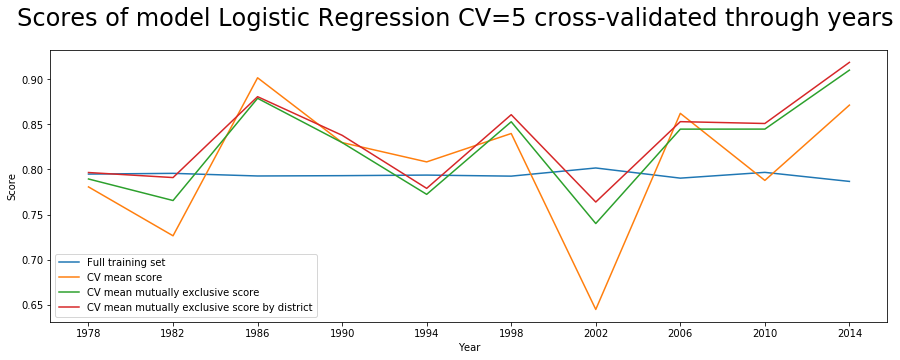

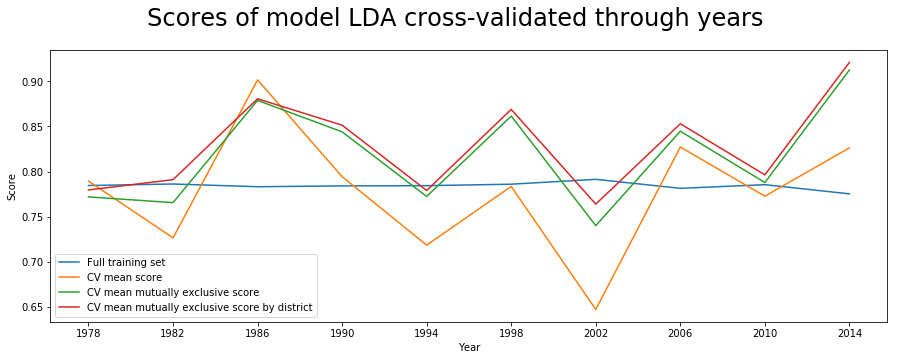

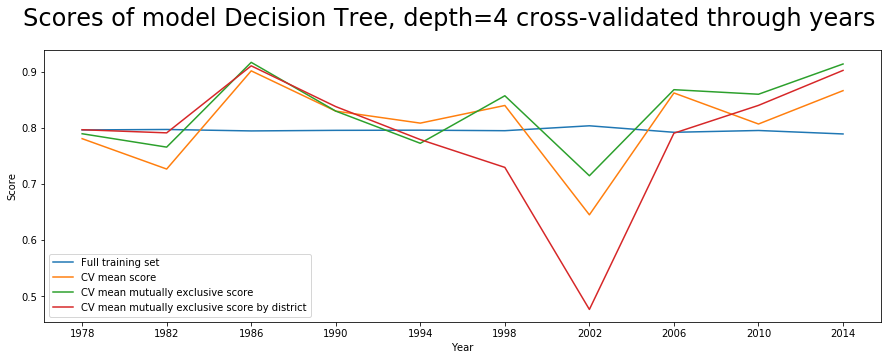

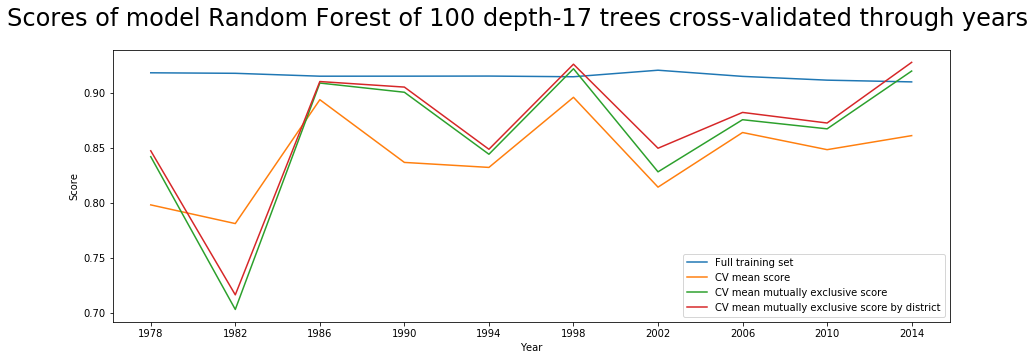

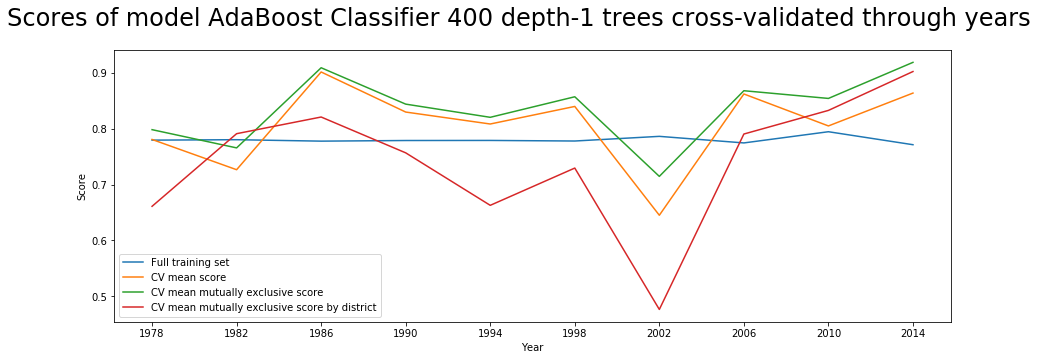

In [18]:
#train models using cross-validation through the years and calculate accuracies
modelListTrain(modelList, train_data, years)

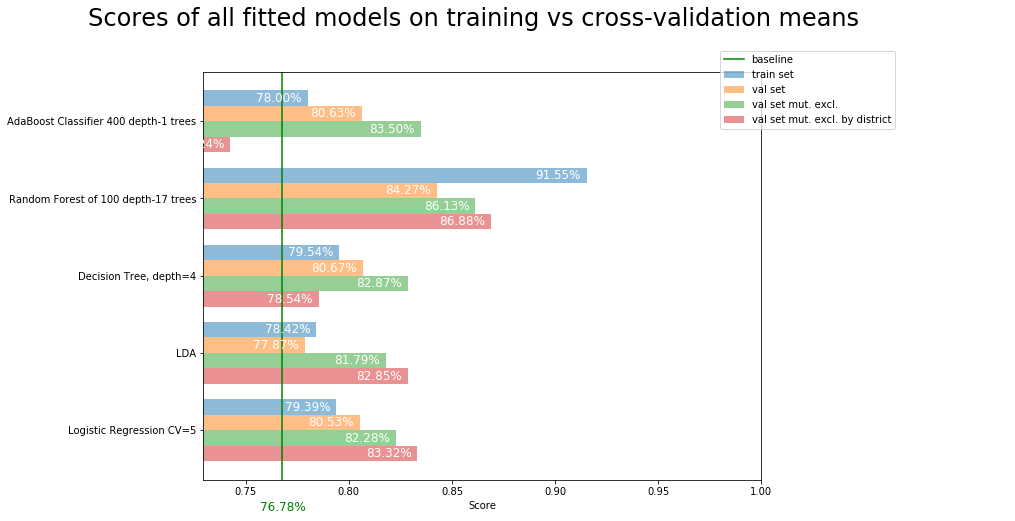

In [19]:
plotModelsScores(modelList, baseline_accuracy)

In [20]:
def featureImportance(x, y):
    scores, pvalues = chi2(x, y)
    featureImportance=pd.DataFrame([list(x), list(pvalues)]).T
    featureImportance.columns=['coeff', 'p-value']
    featureImportance=featureImportance.set_index('coeff')
    display(featureImportance)

In [21]:
#Stacking all models
def predictForStack(df, years, modelList):
    train_data=df.copy()
    stackCols=['state', 'district', 'baseline', 'baseline_proba']
    for i in range(len(modelList)):
        stackCols.append('pred_{}'.format(i))
        stackCols.append('proba_{}'.format(i))
    stackCols.append('party')
    predictionsToStack=pd.DataFrame(columns=stackCols)
    for year in years:        
        #pre_process
        x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
        display(x_train_designFeatures.shape)
        display(x_test_designFeatures.shape)
        #baseline model predictions
        y_pred=baselineTrain(train_data[train_data['year']!=year]).set_index(['state', 'district']).sort_index().astype(float) #train simple average model, remove 2018 results
        y_pred=y_pred.rename(index=str, columns={'party': 'baseline', 'proba': 'baseline_proba'})

        for i, model in enumerate(modelList):
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #district accuracy
            Accu_val_2_byDistrict=districtAccuracy(pred_df[pred_df['won_pred']==1], year)
            display(pred_df.shape)
            display(Accu_val_2_byDistrict)
            #predictions by district and winning party only
            y_pred_i=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
            #y_pred_i['proba_{}'.format(i)]=1-y_pred_i['party']+y_pred_i['rel_won_proba']
            y_pred_i['proba_{}'.format(i)]=y_pred_i['rel_won_proba']
            y_pred_i=y_pred_i.drop(columns=['abs_won_proba', 'won_pred', 'rel_won_proba'])
            y_pred_i=y_pred_i.rename(index=str, columns={'party': 'pred_{}'.format(i)})

            #Add column with current model predictions
            #y_pred=y_pred.join(y_pred_i).fillna(2)
            y_pred = pd.concat([y_pred, y_pred_i], axis=1).fillna(-1)
            y_pred['proba_{}'.format(i)]=y_pred['proba_{}'.format(i)].replace(-1,0)
        y_pred['baseline_proba']=y_pred['baseline_proba'].replace(-1,0)
        #Add last column with actual results
        y_val=winnerFilter(train_data[train_data['year']==year]).set_index(['state', 'district']).sort_index() #extract winner party for each district in 2018
        y_pred=y_pred.join(y_val).dropna()

        #Append all models predictions for current year to the rest
        predictionsToStack=predictionsToStack.append(y_pred.reset_index(drop=False)[stackCols])  
    #if asking only for one year, return predictions by state and district, without actual results 
    if (len(years)==1): 
        return predictionsToStack.drop('party', axis=1).set_index(['state', 'district']).sort_index()
    #if asking for several years, predictions and actual results will be used to fit a stacking model
    return predictionsToStack.drop(columns=['state', 'district'])

In [22]:
#Generate predictions for stacking
predictionsToStack=predictForStack(train_data, years, modelList)

(8212, 14)

(800, 14)

model: Logistic Regression CV=5
year: 2014


(800, 6)

0.9186046511627907

model: LDA
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(800, 6)

0.9209302325581395

model: Decision Tree, depth=4
year: 2014
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 17 districts have no winner or more than one winner


,state,district,won_pred
19,Arkansas,District 4,2.0
46,California,District 33,2.0
88,Florida,District 11,2.0
96,Florida,District 19,2.0
102,Florida,District 24,2.0
127,Hawaii,District 1,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8084,Arkansas,District 4,0.0,0.61008,1.0,1.220159,0.5
8100,Arkansas,District 4,1.0,0.61008,1.0,1.220159,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8084,Arkansas,District 4,0.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.531820,1.0,0.0,0.0,-0.44716,0.931899,-0.989328,1.547732,-0.919776,0.61008
8100,Arkansas,District 4,1.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.475145,0.0,1.0,0.0,0.44670,-0.979479,0.921139,-0.910100,1.543203,0.61008


(800, 6)

0.9023255813953488

model: Random Forest of 100 depth-17 trees
year: 2014


(800, 6)

0.9255813953488372

model: AdaBoost Classifier 400 depth-1 trees
year: 2014
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 21 districts have no winner or more than one winner


,state,district,won_pred
19,Arkansas,District 4,2.0
22,California,District 11,2.0
33,California,District 21,2.0
46,California,District 33,2.0
85,Delaware,At-Large,2.0
96,Florida,District 19,2.0
134,Illinois,District 12,2.0
158,Iowa,District 1,2.0
160,Iowa,District 3,2.0
176,Louisiana,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8084,Arkansas,District 4,0.0,0.491668,1.0,0.983336,0.5
8100,Arkansas,District 4,1.0,0.491668,1.0,0.983336,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8084,Arkansas,District 4,0.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.531820,1.0,0.0,0.0,-0.44716,0.931899,-0.989328,1.547732,-0.919776,0.491668
8100,Arkansas,District 4,1.0,0.845591,-0.519955,-0.520082,-0.232578,2.0,0.475145,0.0,1.0,0.0,0.44670,-0.979479,0.921139,-0.910100,1.543203,0.491668


(800, 6)

0.9023255813953488

(8484, 14)

(528, 14)

model: Logistic Regression CV=5
year: 2010


(528, 6)

0.850909090909091

model: LDA
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(528, 6)

0.7963636363636364

model: Decision Tree, depth=4
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 14 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
87,Florida,District 12,2.0
94,Florida,District 19,2.0
121,Hawaii,District 1,2.0
129,Indiana,District 3,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
158,Maryland,District 1,2.0
178,Missouri,District 4,2.0
219,Ohio,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.726351,1.0,1.452703,0.5
6570,Alabama,District 5,0.0,0.726351,1.0,1.452703,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.349765,0.0,0.0,1.0,-1.120247,-0.983305,0.926577,-0.913630,1.864212,0.726351
6570,Alabama,District 5,0.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.396419,1.0,1.0,1.0,1.116138,0.930866,-0.986352,1.841805,-0.918976,0.726351


(528, 6)

0.84

model: Random Forest of 100 depth-17 trees
year: 2010


(528, 6)

0.8654545454545455

model: AdaBoost Classifier 400 depth-1 trees
year: 2010
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 15 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
84,Delaware,At-Large,2.0
87,Florida,District 12,2.0
94,Florida,District 19,2.0
121,Hawaii,District 1,2.0
129,Indiana,District 3,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
156,Maine,District 1,2.0
158,Maryland,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.502092,1.0,1.004184,0.5
6570,Alabama,District 5,0.0,0.502092,1.0,1.004184,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.349765,0.0,0.0,1.0,-1.120247,-0.983305,0.926577,-0.913630,1.864212,0.502092
6570,Alabama,District 5,0.0,0.680382,-0.513675,-0.514767,-0.228622,1.0,0.396419,1.0,1.0,1.0,1.116138,0.930866,-0.986352,1.841805,-0.918976,0.502092


(528, 6)

0.8327272727272728

(8497, 14)

(515, 14)

model: Logistic Regression CV=5
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.317276,0.0,1.162816,0.272851
5538,Texas,District 22,1.0,0.422770,1.0,1.162816,0.363574
5539,Texas,District 22,1.0,0.422770,1.0,1.162816,0.363574


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.317276
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.422770
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.422770


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(515, 6)

0.8529411764705882

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


model: LDA
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.414298,0.0,1.441456,0.287417
5538,Texas,District 22,1.0,0.513579,1.0,1.441456,0.356292
5539,Texas,District 22,1.0,0.513579,1.0,1.441456,0.356292


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.414298
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.513579
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.513579


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(515, 6)

0.8529411764705882

model: Decision Tree, depth=4
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 46 districts have no winner or more than one winner


,state,district,won_pred
7,Alaska,At-Large,2.0
15,Arizona,District 8,2.0
34,California,District 22,2.0
61,California,District 48,2.0
63,California,District 5,2.0
64,California,District 50,2.0
74,Colorado,District 3,2.0
76,Colorado,District 5,2.0
78,Colorado,District 7,2.0
83,Connecticut,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5595,Alaska,At-Large,0.0,0.29855,1.0,0.597099,0.5
5602,Alaska,At-Large,1.0,0.29855,1.0,0.597099,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5595,Alaska,At-Large,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.29855
5602,Alaska,At-Large,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.29855


(515, 6)

0.7904411764705882

model: Random Forest of 100 depth-17 trees
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.301310,0.0,1.751311,0.172048
5538,Texas,District 22,1.0,0.725001,1.0,1.751311,0.413976
5539,Texas,District 22,1.0,0.725001,1.0,1.751311,0.413976


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.301310
5538,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.725001
5539,Texas,District 22,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.725001


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(515, 6)

0.8823529411764706

model: AdaBoost Classifier 400 depth-1 trees
year: 2006
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 46 districts have no winner or more than one winner


,state,district,won_pred
7,Alaska,At-Large,2.0
15,Arizona,District 8,2.0
34,California,District 22,2.0
61,California,District 48,2.0
63,California,District 5,2.0
64,California,District 50,2.0
74,Colorado,District 3,2.0
76,Colorado,District 5,2.0
78,Colorado,District 7,2.0
83,Connecticut,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5595,Alaska,At-Large,0.0,0.465796,1.0,0.931592,0.5
5602,Alaska,At-Large,1.0,0.465796,1.0,0.931592,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5595,Alaska,At-Large,0.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,0.0,0.0,0.0,-0.413188,-0.983816,0.986461,-0.915253,0.320730,0.465796
5602,Alaska,At-Large,1.0,0.539995,-0.513882,-0.514142,0.012917,0.0,0.168881,1.0,1.0,0.0,0.411570,0.989402,-0.985690,0.317510,-0.919063,0.465796


(515, 6)

0.7904411764705882

(8581, 14)

(431, 14)

model: Logistic Regression CV=5
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333
4460,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333
4461,Louisiana,District 1,1.0,0.33009,1.0,0.990271,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.33009


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(431, 6)

0.7639484978540773

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


model: LDA
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333
4460,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333
4461,Louisiana,District 1,1.0,0.404763,1.0,1.214288,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.404763


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(431, 6)

0.7639484978540773

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 122 districts have no winner or more than one winner


model: Decision Tree, depth=4
year: 2002
List of affected districts:


,state,district,won_pred
0,Alabama,District 1,2.0
1,Alabama,District 2,2.0
2,Alabama,District 3,2.0
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
8,Arizona,District 2,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
11,Arizona,District 5,2.0
12,Arizona,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4254,Alabama,District 1,0.0,0.289622,1.0,0.579245,0.5
4255,Alabama,District 1,1.0,0.289622,1.0,0.579245,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4254,Alabama,District 1,0.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,0.0,0.0,0.0,-0.123616,-0.980537,0.983147,-0.906975,0.702366,0.289622
4255,Alabama,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.989280,0.700824,-0.916458,0.289622


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(431, 6)

0.47639484978540775

model: Random Forest of 100 depth-17 trees
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.746365,1.0,2.239094,0.333333
4460,Louisiana,District 1,1.0,0.746365,1.0,2.239094,0.333333
4461,Louisiana,District 1,1.0,0.746365,1.0,2.239094,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.746365
4460,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.746365
4461,Louisiana,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.98928,0.700824,-0.916458,0.746365


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(431, 6)

0.8497854077253219

model: AdaBoost Classifier 400 depth-1 trees
year: 2002
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 122 districts have no winner or more than one winner


,state,district,won_pred
0,Alabama,District 1,2.0
1,Alabama,District 2,2.0
2,Alabama,District 3,2.0
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
8,Arizona,District 2,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
11,Arizona,District 5,2.0
12,Arizona,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4254,Alabama,District 1,0.0,0.461309,1.0,0.922618,0.5
4255,Alabama,District 1,1.0,0.461309,1.0,0.922618,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4254,Alabama,District 1,0.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,0.0,0.0,0.0,-0.123616,-0.980537,0.983147,-0.906975,0.702366,0.461309
4255,Alabama,District 1,1.0,0.399833,-0.527135,-0.526753,0.012853,3.0,0.168029,1.0,1.0,0.0,0.124427,0.992969,-0.989280,0.700824,-0.916458,0.461309


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(431, 6)

0.47639484978540775

(8781, 14)

(231, 14)

model: Logistic Regression CV=5
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.289641,0.0,0.883575,0.327805
3719,California,District 1,1.0,0.296967,1.0,0.883575,0.336097
3720,California,District 1,1.0,0.296967,1.0,0.883575,0.336097


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.289641
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.296967
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.296967


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(231, 6)

0.860655737704918

model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(231, 6)

0.8688524590163934

model: Decision Tree, depth=4
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 33 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,3.0
1,California,District 10,2.0
14,California,District 22,2.0
16,California,District 24,2.0
19,California,District 27,2.0
26,California,District 34,2.0
28,California,District 36,2.0
34,California,District 41,2.0
35,California,District 42,2.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.291344,1.0,0.874032,0.333333
3719,California,District 1,1.0,0.291344,1.0,0.874032,0.333333
3720,California,District 1,1.0,0.291344,1.0,0.874032,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.291344
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.291344
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.291344


(231, 6)

0.7295081967213115

model: Random Forest of 100 depth-17 trees
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.173844,0.0,0.847132,0.205215
3719,California,District 1,1.0,0.336644,1.0,0.847132,0.397393
3720,California,District 1,1.0,0.336644,1.0,0.847132,0.397393


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.173844
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.336644
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.336644


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(231, 6)

0.9262295081967213

model: AdaBoost Classifier 400 depth-1 trees
year: 1998
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 33 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,3.0
1,California,District 10,2.0
14,California,District 22,2.0
16,California,District 24,2.0
19,California,District 27,2.0
26,California,District 34,2.0
28,California,District 36,2.0
34,California,District 41,2.0
35,California,District 42,2.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.464095,1.0,1.392285,0.333333
3719,California,District 1,1.0,0.464095,1.0,1.392285,0.333333
3720,California,District 1,1.0,0.464095,1.0,1.392285,0.333333


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,1.0,0.0,1.0,-0.305822,1.226754,-0.988663,0.359979,-0.918819,0.464095
3719,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.464095
3720,California,District 1,1.0,0.260909,-0.52054,-0.52013,0.990193,1.0,0.166051,0.0,1.0,1.0,0.306634,-0.982355,1.219411,-0.911461,0.360843,0.464095


(231, 6)

0.7295081967213115

(8845, 14)

(167, 14)

model: Logistic Regression CV=5
year: 1994


(167, 6)

0.7790697674418605

model: LDA
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(167, 6)

0.7790697674418605

model: Decision Tree, depth=4
year: 1994


(167, 6)

0.7790697674418605

model: Random Forest of 100 depth-17 trees
year: 1994


(167, 6)

0.8488372093023255

model: AdaBoost Classifier 400 depth-1 trees
year: 1994
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 28 districts have no winner or more than one winner


,state,district,won_pred
1,California,District 10,2.0
2,California,District 11,2.0
5,California,District 14,2.0
7,California,District 16,2.0
8,California,District 17,2.0
10,California,District 19,2.0
14,California,District 22,2.0
17,California,District 25,2.0
22,California,District 30,2.0
28,California,District 36,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3384,California,District 10,1.0,0.463738,1.0,0.927477,0.5
3385,California,District 10,0.0,0.463738,1.0,0.927477,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3384,California,District 10,1.0,0.127169,-0.522382,-0.522398,0.983122,1.0,0.165433,0.0,0.0,1.0,-1.158372,-0.982185,1.217270,-0.909274,0.738740,0.463738
3385,California,District 10,0.0,0.127169,-0.522382,-0.522398,0.983122,1.0,0.165433,1.0,1.0,1.0,1.158718,1.225116,-0.988889,0.735619,-0.916949,0.463738


(167, 6)

0.6627906976744186

(8871, 14)

(141, 14)

model: Logistic Regression CV=5
year: 1990


(141, 6)

0.8378378378378378

model: LDA
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(141, 6)

0.8513513513513513

model: Decision Tree, depth=4
year: 1990


(141, 6)

0.8378378378378378

model: Random Forest of 100 depth-17 trees
year: 1990


(141, 6)

0.8513513513513513

model: AdaBoost Classifier 400 depth-1 trees
year: 1990
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 14 districts have no winner or more than one winner


,state,district,won_pred
3,California,District 12,2.0
5,California,District 14,2.0
6,California,District 15,2.0
21,California,District 29,2.0
33,California,District 40,2.0
35,California,District 42,2.0
45,Colorado,District 4,2.0
49,Connecticut,District 3,2.0
54,Maine,District 1,2.0
57,Maryland,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3056,California,District 12,0.0,0.463908,1.0,0.927815,0.5
3057,California,District 12,1.0,0.463908,1.0,0.927815,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3056,California,District 12,0.0,-0.005428,-0.518658,-0.519177,2.010969,1.0,0.165184,0.0,1.0,1.0,1.198896,-0.982792,1.454141,-0.909370,0.768253,0.463908
3057,California,District 12,1.0,-0.005428,-0.518658,-0.519177,2.010969,1.0,0.165184,1.0,0.0,1.0,-1.198020,1.462042,-0.989488,0.764941,-0.917030,0.463908


(141, 6)

0.7567567567567568

(8880, 14)

(132, 14)

model: Logistic Regression CV=5
year: 1986


(132, 6)

0.8805970149253731

model: LDA
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(132, 6)

0.8805970149253731

model: Decision Tree, depth=4
year: 1986
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
61,Utah,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2738,Utah,District 1,0.0,0.96796,1.0,1.935919,0.5
2739,Utah,District 1,1.0,0.96796,1.0,1.935919,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2738,Utah,District 1,0.0,-0.13777,3.577027,0.024361,0.586667,1.0,0.165098,0.0,1.0,1.0,0.998158,-0.982218,1.122755,-0.909165,1.087541,0.96796
2739,Utah,District 1,1.0,-0.13777,0.505148,0.567893,0.586667,1.0,0.165098,1.0,0.0,1.0,-0.997105,1.130268,-0.988673,1.081815,-0.916631,0.96796


(132, 6)

0.9104477611940298

model: Random Forest of 100 depth-17 trees
year: 1986


(132, 6)

0.9104477611940298

model: AdaBoost Classifier 400 depth-1 trees
year: 1986
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 12 districts have no winner or more than one winner


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
30,California,District 38,2.0
44,Colorado,District 3,2.0
46,Colorado,District 5,2.0
49,Hawaii,District 1,2.0
51,Maine,District 1,2.0
53,Maryland,District 4,2.0
54,Maryland,District 8,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.464078,1.0,0.928156,0.5
2736,California,District 12,0.0,0.464078,1.0,0.928156,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.13777,-0.518812,-0.519171,0.586667,1.0,0.165098,1.0,0.0,1.0,-0.997105,1.130268,-0.988673,1.081815,-0.916631,0.464078
2736,California,District 12,0.0,-0.13777,-0.518812,-0.519171,0.586667,1.0,0.165098,0.0,1.0,1.0,0.998158,-0.982218,1.122755,-0.909165,1.087541,0.464078


(132, 6)

0.8208955223880597

(8884, 14)

(128, 14)

model: Logistic Regression CV=5
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.440840,1.0,1.309889,0.336548
2528,California,District 43,0.0,0.428209,0.0,1.309889,0.326905
2569,California,District 43,1.0,0.440840,1.0,1.309889,0.336548


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.440840
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.428209
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.440840


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(128, 6)

0.7910447761194029

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


model: LDA
year: 1982
List of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.454979,1.0,1.357109,0.335256
2528,California,District 43,0.0,0.447151,0.0,1.357109,0.329488
2569,California,District 43,1.0,0.454979,1.0,1.357109,0.335256


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.454979
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.447151
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.454979


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(128, 6)

0.7910447761194029

model: Decision Tree, depth=4
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.411719,1.0,1.112637,0.370039
2528,California,District 43,0.0,0.289200,0.0,1.112637,0.259923
2569,California,District 43,1.0,0.411719,1.0,1.112637,0.370039


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.411719
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.289200
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.411719


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(128, 6)

0.7910447761194029

model: Random Forest of 100 depth-17 trees
year: 1982


(128, 6)

0.7910447761194029

model: AdaBoost Classifier 400 depth-1 trees
year: 1982
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.472383,1.0,1.40808,0.335480
2528,California,District 43,0.0,0.463314,0.0,1.40808,0.329039
2569,California,District 43,1.0,0.472383,1.0,1.40808,0.335480


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.472383
2528,California,District 43,0.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,0.0,1.0,1.0,0.714435,-0.982004,1.122439,-0.912056,2.090959,0.463314
2569,California,District 43,1.0,-0.270155,-0.520986,-0.520956,0.586489,1.0,0.165059,1.0,0.0,1.0,-0.713835,1.130462,-0.988899,2.078905,-0.920097,0.472383


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party


(128, 6)

0.7910447761194029

(8898, 14)

(114, 14)

model: Logistic Regression CV=5
year: 1978


(114, 6)

0.7966101694915254

model: LDA
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(114, 6)

0.7796610169491526

model: Decision Tree, depth=4
year: 1978


(114, 6)

0.7966101694915254

model: Random Forest of 100 depth-17 trees
year: 1978


(114, 6)

0.847457627118644

model: AdaBoost Classifier 400 depth-1 trees
year: 1978
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 17 districts have no winner or more than one winner


,state,district,won_pred
6,California,District 15,2.0
7,California,District 16,2.0
9,California,District 18,2.0
15,California,District 23,2.0
19,California,District 27,2.0
25,California,District 33,2.0
29,California,District 37,2.0
31,California,District 39,2.0
32,California,District 4,2.0
33,California,District 40,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2262,California,District 15,0.0,0.46353,1.0,0.927061,0.5
2270,California,District 15,1.0,0.46353,1.0,0.927061,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2262,California,District 15,0.0,-0.402405,-0.520647,-0.52073,-0.645163,2.0,0.164926,1.0,1.0,0.0,2.140912,0.834796,-0.988979,0.736917,-0.917357,0.46353
2270,California,District 15,1.0,-0.402405,-0.520647,-0.52073,-0.645163,2.0,0.164926,0.0,0.0,0.0,-2.140297,-0.982093,0.826971,-0.909514,0.739860,0.46353


(114, 6)

0.6610169491525424

In [23]:
#display prediction table for stacking and model names legenda
display(predictionsToStack.head())
for i in range(len(modelList)):
    print(i, modelList[i]['name'])

,baseline,baseline_proba,pred_0,proba_0,pred_1,proba_1,pred_2,proba_2,pred_3,proba_3,pred_4,proba_4,party
0,1.0,1.000000,1.0,0.803118,1.0,0.699685,1.0,0.963973,1.0,0.996604,1.0,0.614489,1.0
1,1.0,0.857143,1.0,0.880866,1.0,0.788695,1.0,0.988990,1.0,0.998543,1.0,0.693096,1.0
2,1.0,1.000000,1.0,0.885505,1.0,0.784504,1.0,0.988990,1.0,0.998588,1.0,0.684549,1.0
3,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.0,0.571429,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


0 Logistic Regression CV=5
1 LDA
2 Decision Tree, depth=4
3 Random Forest of 100 depth-17 trees
4 AdaBoost Classifier 400 depth-1 trees


In [24]:
#Select which model predictions to stack
selCols=[2,4,6,8,10,12]
X=predictionsToStack.iloc[:,selCols].drop('party', axis=1).astype(float)
y=predictionsToStack.iloc[:,selCols]['party'].astype(float)
stackingModel = LogisticRegression(C=1000, solver='lbfgs').fit(X,y)
stackingModel.score(X,y)

0.8801186943620178

In [25]:
#split dataset using 2018 data as test set
year=2018
data=house_df[(house_df['year']>=yearStart)]
predictions2018toStack=predictForStack(data, [year], modelList)

(9012, 14)

(840, 14)

model: Logistic Regression CV=5
year: 2018


(840, 6)

0.8666666666666667

model: LDA
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(840, 6)

0.8597701149425288

model: Decision Tree, depth=4
year: 2018
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 45 districts have no winner or more than one winner


,state,district,won_pred
15,Arizona,District 8,2.0
16,Arizona,District 9,2.0
85,Connecticut,District 5,2.0
93,Florida,District 15,2.0
95,Florida,District 17,2.0
106,Florida,District 27,2.0
128,Hawaii,District 1,2.0
130,Idaho,District 1,2.0
131,Idaho,District 2,2.0
146,Illinois,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9233,Arizona,District 8,1.0,0.582627,1.0,1.165254,0.5
9279,Arizona,District 8,0.0,0.582627,1.0,1.165254,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9233,Arizona,District 8,1.0,0.914081,-0.520621,-0.520842,-1.642359,0.0,0.575357,1.0,1.0,0.0,0.660724,0.596777,-0.989013,0.142171,-0.918011,0.582627
9279,Arizona,District 8,0.0,0.914081,-0.520621,-0.520842,-1.642359,0.0,0.922321,0.0,0.0,0.0,-0.660130,-0.982214,0.589160,-0.910237,0.141229,0.582627


(840, 6)

0.8183908045977012

model: Random Forest of 100 depth-17 trees
year: 2018


(840, 6)

0.8666666666666667

model: AdaBoost Classifier 400 depth-1 trees
year: 2018
List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: 42 districts have no winner or more than one winner


,state,district,won_pred
15,Arizona,District 8,2.0
16,Arizona,District 9,2.0
85,Connecticut,District 5,2.0
93,Florida,District 15,2.0
95,Florida,District 17,2.0
106,Florida,District 27,2.0
128,Hawaii,District 1,2.0
131,Idaho,District 2,2.0
146,Illinois,District 6,2.0
169,Kentucky,District 3,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9233,Arizona,District 8,1.0,0.489327,1.0,0.978655,0.5
9279,Arizona,District 8,0.0,0.489327,1.0,0.978655,0.5


Data of the occurrence from list:


,state,district,party,year,first_time_elected,count_victories,president_overall_avg_job_approval,partisanship,Log10fundraising,own_president_party,own_last_house_majority,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9233,Arizona,District 8,1.0,0.914081,-0.520621,-0.520842,-1.642359,0.0,0.575357,1.0,1.0,0.0,0.660724,0.596777,-0.989013,0.142171,-0.918011,0.489327
9279,Arizona,District 8,0.0,0.914081,-0.520621,-0.520842,-1.642359,0.0,0.922321,0.0,0.0,0.0,-0.660130,-0.982214,0.589160,-0.910237,0.141229,0.489327


(840, 6)

0.8275862068965517

In [26]:
selCols_=selCols[:-1]
X=predictions2018toStack.iloc[:,selCols_].copy().astype(float)
X['stackedPredictions']=stackingModel.predict(X)
X, y_pred_stacked_2018=X.drop('stackedPredictions', axis=1), X['stackedPredictions']
display(districtAccuracy(y_pred_stacked_2018, 2018, 'stackedPredictions', 0)) #, partyWonCol='party', set_index=1)
pred2018=districtPredictions(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #year, partyWonCol='party', set_index=1):

0.8666666666666667

In [27]:
#calculate stacked probabilities  
probabilities=list(np.array(selCols_)+1)
pred2018['proba']=predictions2018toStack.iloc[:,probabilities].dot(stackingModel.coef_.T)/np.sum(stackingModel.coef_)

In [28]:
#Salve .csv file
pred2018=pred2018.rename(index=str, columns={'partyWon':'won', 'stackedPredictions':'won_pred', 'proba':'rel_won_proba'})
pred2018['correct_pred']=(pred2018['won']==pred2018['won_pred'])
pred2018.to_csv('data/final_results_map.csv', index=True)
display(pred2018.head())

won  won_pred  rel_won_proba  correct_pred
state   district                                              
Alabama District 1    1       1.0       0.976352          True
        District 2    1       1.0       0.980073          True
        District 3    1       1.0       0.705356          True
        District 4    1       1.0       1.019356          True
        District 5    1       1.0       0.983157          True

In [29]:
pred2018.describe()

,won,won_pred,rel_won_proba
count,435.000000,435.000000,435.000000
mean,0.471264,0.558621,0.832566
std,0.499748,0.497123,0.162353
min,0.000000,0.000000,0.373981
25%,0.000000,0.000000,0.727652
50%,0.000000,1.000000,0.841037
75%,1.000000,1.000000,0.994275
max,1.000000,1.000000,1.037112


In [30]:
#find best depth for decision tree
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
            
    #fit model
    depths=list(range(1,41)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_designFeatures, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_designFeatures, y_train)
        scores_train.append(dt.score(x_train_designFeatures, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [31]:
#plot staged scores on ax
def plotScoreVsIter(boost, X, y, ax, label='Train set, AdaBoost', linestyle='-', color='blue'):
    xticks=np.arange(1,len(boost.estimators_)+1)
    ax.plot(xticks, list(boost.staged_score(X,y)), linestyle, c=color, label = label)

#plot a list of models scores
def PlotAdaBoost3(modelList, X_train, y_train, X_test, y_test, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(title, fontsize=24, y=1.0)
    colors=sns.color_palette('colorblind', len(modelList))
    for model, c in zip(modelList, colors):
        plotScoreVsIter(model['model'], X_train, y_train, ax, 'Train set, {}'.format(model['name']), '--', c)
        plotScoreVsIter(model['model'], X_test, y_test, ax, 'Test set, {}'.format(model['name']), color=c)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('Score')
    lgd = ax.legend(bbox_to_anchor=(1, 0.1), loc='lower left', borderaxespad=1);
    fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight') #to avoid cutoff legend
    #I choosed to use the same color for train and test sets and changing only the linestyle
    #It is more convenient when displaying more than one boosting model
    #As a future improvement I would split the legend in 2, one for colors and one for linestyle.

In [32]:
#find best depth for decision tree and best n_estimators
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
    
    #fit AdaBoost classifiers for tree depth = 1,2,4
    n_trees=800
    lrate=0.01
    for i in [1,2,4]:
        abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), n_estimators=n_trees, learning_rate=lrate)
        model=dict()
        model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, i)
        model['model']=abc.fit(x_train_designFeatures, y_train)
        model['training accuracy']=model['model'].score(x_train_designFeatures, y_train)
        model['test accuracy']=model['model'].score(x_val_designFeatures, y_val)
        modelList.append(model)
    plotList=modelList[-3:]
    title='{}. Boosting score vs number of iterations'.format(year)
    PlotAdaBoost3(plotList, x_train_designFeatures, y_train, x_val_designFeatures, y_val, title)

In [33]:
#Consolidate district results by party, instead that by candidate
#winner_pred=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
#actual_winners=test_data[test_data['won']==1].set_index(['state', 'district']).sort_index()
#winner_pred['won_pred'].astype(int)==actual_winners['won'].astype(int)
#final_results=pd.DataFrame(columns = ['won', 'won_pred'] )
#final_results['won_pred']=winner_pred['party'].astype(int).replace([0, 1], ['D', 'R'])
#final_results['won']=actual_winners['party']
#final_results['correct_pred']=(final_results['won_pred']==final_results['won'])
#print('Correct predictions: {} on a total of {} districts ({:.2%})\n'.format(sum(final_results['correct_pred']),
#                                                                       len(final_results['correct_pred']),
#                                                                       sum(final_results['correct_pred'])/len(final_results['correct_pred'])))

#print how many republican, how many democrat districts
#DEM=final_results[final_results['won_pred']=='D']
#REP=final_results[final_results['won_pred']=='R']
#print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
#DEM=final_results[final_results['won']=='D']
#REP=final_results[final_results['won']=='R']
#print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))
#final_results['abs_won_proba']=winner_pred['abs_won_proba']
#final_results['rel_won_proba']=winner_pred['rel_won_proba']

#print('\nFirst 5 correct predictions:')
#display(final_results[final_results['correct_pred']==True].head())

#print('First 5 wrong predictions:')
#display(final_results[final_results['correct_pred']==False].head())
#final_results.to_csv('data/final_results_map.csv', index=True)

In [34]:

featureImportance(x_train_designFeatures, y_train)

NameError: name 'x_train_designFeatures' is not defined

In [ ]:
plt.hist(pred_df['abs_won_proba'])

In [ ]:
plt.hist(pred2018['rel_won_proba'])